In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle
from os import listdir
from os.path import isfile, join

plt.rcParams["figure.figsize"] = (20,10)

%matplotlib inline

In [2]:
color_dict = {
    1610612737: ('#E13A3E', 'ATL'),
    1610612738: ('#008348', 'BOS'),
    1610612751: ('#061922', 'BKN'),
    1610612766: ('#1D1160', 'CHA'),
    1610612741: ('#CE1141', 'CHI'),
    1610612739: ('#860038', 'CLE'),
    1610612742: ('#007DC5', 'DAL'),
    1610612743: ('#4D90CD', 'DEN'),
    1610612765: ('#006BB6', 'DET'),
    1610612744: ('#FDB927', 'GSW'),
    1610612745: ('#CE1141', 'HOU'),
    1610612754: ('#00275D', 'IND'),
    1610612746: ('#ED174C', 'LAC'),
    1610612747: ('#552582', 'LAL'),
    1610612763: ('#0F586C', 'MEM'),
    1610612748: ('#98002E', 'MIA'),
    1610612749: ('#00471B', 'MIL'),
    1610612750: ('#005083', 'MIN'),
    1610612740: ('#002B5C', 'NOP'),
    1610612752: ('#006BB6', 'NYK'),
    1610612760: ('#007DC3', 'OKC'),
    1610612753: ('#007DC5', 'ORL'),
    1610612755: ('#006BB6', 'PHI'),
    1610612756: ('#1D1160', 'PHX'),
    1610612757: ('#E03A3E', 'POR'),
    1610612758: ('#724C9F', 'SAC'),
    1610612759: ('#BAC3C9', 'SAS'),
    1610612761: ('#000000', 'TOR'),
    1610612762: ('#00471B', 'UTA'),
    1610612764: ('#002B5C', 'WAS'),
}

In [60]:
def draw_court(game_id, ii, jj):
    data_dir = 'raptors/'
    path = './raptors/data'
    extension = 'pkl'
    
    pickle_file = join(path, game_id + '.pkl')
    
    with open(pickle_file, 'rb') as handle:
        datta = pickle.load(handle)

    
    court_path = data_dir + 'nba_court_T.png'
    num_events = len(datta['events'])
    
    player_fields = datta['events'][0]['home']['players'][0].keys()
    # CHANGE THIS
    # specify an event number

    home_players = pd.DataFrame(data=[i for i in datta['events'][0]['home']['players']], columns=player_fields)
    away_players = pd.DataFrame(data=[i for i in datta['events'][0]['visitor']['players']], columns=player_fields)
    players = pd.merge(home_players, away_players, how='outer')
    jerseydict = dict(zip(players.playerid.values, players.jersey.values))

    # get the position of the players and the ball throughout the event
    ball_xy = np.array([x[5][0][2:5] for x in datta['events'][ii]['moments']]) #create matrix of ball data
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][ii]['moments']]) #create matrix of player data

    # get the play by play data for this clip
    playbyplay = datta['events'][ii]['playbyplay']
    team_1_xy_mean = -np.ones((len(player_xy),2))
    team_2_xy_mean = -np.ones((len(player_xy),2))


    # CHANGE THIS
    # plot a certain frame:
    #jj = (len(player_xy) - 1) / 2

    print('event ' + str(ii) + '/' + str(num_events) + ", moment: "+ str(jj) + '/'+ str(len(player_xy)))
    fig = plt.figure()
    ax = plt.gca() #create axis object


    img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

    plt.imshow(img, extent=[0,94,0,50], zorder=0)  # show the image.

    # get player and ball data for the momenet
    ball = ball_xy[jj]
    player = player_xy[jj]

    # plot clock info
    clock_info = ax.annotate('', xy=[94.0/2 - 6.0/1.5 +0.1, 50 - 6.0/1.5 -0.35],
        color='black', horizontalalignment='center', verticalalignment='center')

    if not datta['events'][ii]['moments'][jj][0] == None:
        quarter = datta['events'][ii]['moments'][jj][0]
    else:
        quarter = 0

    if not datta['events'][ii]['moments'][jj][2] == None:
        game_clock = datta['events'][ii]['moments'][jj][2]
    else:
        game_clock = 0

    if not datta['events'][ii]['moments'][jj][3] == None:
        game_shot = datta['events'][ii]['moments'][jj][3]
    else:
        game_shot = 0

    clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
        quarter,
        int(game_clock) % 3600 // 60,
        int(game_clock) % 60,
        game_shot)
    clock_info.set_text(clock_test)

    # the event title
    temp = str(datta['events'][ii]['home']['abbreviation'])+\
        ' vs. ' + str(datta['events'][ii]['visitor']['abbreviation'])+\
        ' (' + str(ii) + ',  ' + str(jj) + ')' +\
        '\n'
    counter = 0 
    for idx, pp in playbyplay.iterrows():
        counter = counter + 1
        if counter > 5:
            break
        temp = temp + str(pp['HOMEDESCRIPTION'])+ " , " +\
                str(pp['VISITORDESCRIPTION'])+ " , "+\
                str(pp['PCTIMESTRING'])+ " , "+\
                str(pp['event_str'])  + '\n'


    plt.title(temp)

    for kk in range(player.shape[0]): #create circle object and text object for each player

        #
        #kk = 1
        #
        team_id = player[kk,0]
        player_id = player[kk,1]
        xx = player[kk,2]
        yy  =player[kk, 3]

        # player circle
        player_circ = plt.Circle((xx,yy), 2.2,
                        facecolor=color_dict[team_id][0],edgecolor='k')
        ax.add_artist(player_circ)

        # player jersey # (text)
        ax.text(xx,yy,jerseydict[player_id],color='w',ha='center',va='center')

    # draw the ball
    ball_circ = plt.Circle((ball[0], ball[1]), ball[2]/3, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)

    # add the average position of each team tp the frame
    team_ids = np.unique(player[:,0])

    team_1_xy = player[player[:,0] == team_ids[0]]
    team_1_xy = team_1_xy[:,[2,3]]
    team_1_xy_mean[jj,:] = np.mean(team_1_xy,0)
    plt.plot(team_1_xy_mean[:jj+1,0],team_1_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[0]][0],
             alpha=0.2)


    team_2_xy = player[player[:,0] == team_ids[1]]
    team_2_xy = team_2_xy[:,[2,3]]
    team_2_xy_mean[jj,:] = np.mean(team_2_xy,0)
    plt.plot(team_2_xy_mean[:jj+1,0],team_2_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[1]][0],
             alpha=0.2)

    plt.xlim([0,94])
    plt.ylim([0,50])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)


In [4]:
def time_conversion(quarter, time_left_in_quarter):
    time_passed = quarter * 12 * 60 - time_left_in_quarter
    time_left_in_game = (48 * 60) - time_passed
    return time_left_in_game

In [5]:
# Find the scoring with assis moments
def get_events(ddata):
    ast_list = []
    attacker = []
    shooter = []
    assist = []
    ast_events = []
    
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']
    num_events = len(datta['events'])
    
    # Look through the data locate where the scoring with assist happens
    for i in xrange(num_events):
        playbyplay = datta['events'][i]['playbyplay']
        for idx, play in playbyplay.iterrows():
            if play['HOMEDESCRIPTION'] != None:
                if play['HOMEDESCRIPTION'].find(' AST)') != -1:
                    # print play['HOMEDESCRIPTION']
                    quarter = play['PERIOD']
                    time_left_in_quarter = play['time_left']
                    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                    player1 = play['PLAYER1_ID']
                    player2 = play['PLAYER2_ID']
                    # print time_left_in_quarter, time_left_in_game
                    ast_list.append(time_left_in_game)
                    attacker.append(home_team)
                    shooter.append(player1)
                    assist.append(player2)
                    ast_events.append(i)
            if play['VISITORDESCRIPTION'] != None:
                if play['VISITORDESCRIPTION'].find(' AST)') != -1:
                    # print play['VISITORDESCRIPTION']
                    quarter = play['PERIOD']
                    time_left_in_quarter = play['time_left']                
                    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                    player1 = play['PLAYER1_ID']
                    player2 = play['PLAYER2_ID']
                    # print time_left_in_quarter, time_left_in_game
                    ast_list.append(time_left_in_game)
                    attacker.append(away_team)
                    shooter.append(player1)
                    assist.append(player2)
                    ast_events.append(i)

    ast_events = list(set(ast_events))
    ast_events.sort()
    ast_times, index = np.unique(ast_list, return_index = True)
    attacker = np.array([attacker[i] for i in index])
    shooter = np.array([shooter[i] for i in index])
    assist = np.array([assist[i] for i in index])
    event_data = pd.DataFrame(data={'attack': attacker, 'time':ast_times, 'shooter': shooter, 'assist':assist})
    
    return event_data

In [6]:
# Get the start time of each event
def combine_moments(datta):
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']

    num_events = len(datta['events'])
    event_start_time = []
    for i in xrange(num_events):
        moment = datta['events'][i]['moments']
        quarter = moment[0][0]
        time_left_in_quarter = moment[0][2]
        event_start_time.append(time_conversion(quarter, time_left_in_quarter))
    
    # Get the list of frames of events where AST happens wihtout overlap
    moment_data = []
    moment_location = []
    for i in reversed(xrange(num_events)):
        if i % 20 == 0:
            print i, num_events
        moment = datta['events'][i]['moments']
        pbp = datta['events'][i]['playbyplay'].empty
        for j in reversed(xrange(len(moment))):
            quarter = moment[j][0]
            time_left_in_quarter = moment[j][2]
            time_left_in_game = time_conversion(quarter, time_left_in_quarter)

            if time_left_in_game == event_start_time[i]:
                break

            # Get meta data
            a = moment[j][:4]
            a.append(i)
            a.append(j)
            a.append(pbp)

            moment_data.append(a)        
            # Get location data
            location = pd.DataFrame(moment[j][5])
            ball = location.iloc[0, :]
            home = location[location[0] == home_team]
            away = location[location[0] == away_team]
            moment_location.append([ball, home, away])
    return moment_data, moment_location

In [7]:
# Go through and find frames exactly where shot happens and when assist happens
# Check when the clock resets

def get_shot(moment_data, moment_location, event_data, slack_time=5):
    search_counter = 0
    prev_shot_clock = 24
    moment_list = []
    event_list = []
    prev_time_left_in_game = 60 * 48
    for i in xrange(len(moment_data)):
        quarter = moment_data[i][0]
        time_left_in_quarter = moment_data[i][2]
        shot_clock = moment_data[i][3]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)
        search_time = event_data.time[search_counter]

        if prev_shot_clock > shot_clock and shot_clock != None \
                                        and prev_shot_clock != None \
                                        and prev_time_left_in_game > event_data.time[search_counter]:
            # print prev_shot_clock, shot_clock, time_left_in_game
            # print "Shot Clock Reset", time_left_in_game, prev_shot_clock, shot_clock
            if time_left_in_game > search_time - slack_time:
                if (prev_shot_clock - shot_clock) > 0.5 and prev_shot_clock > 23.9 \
                                                        and moment_data[i][-1] == False \
                                                        and (time_left_in_game - event_data.time[search_counter]) < 5:
                    # print 'shot', moment_data[i], prev_time_left_in_game, event_data.time[search_counter], prev_shot_clock, shot_clock, search_counter
                    moment_list.append(i)
                    event_list.append(search_counter)
                search_counter = search_counter + 1

        prev_shot_clock = shot_clock
        prev_time_left_in_game = time_left_in_game

        if search_counter >= len(event_data):
            break
    return event_list, moment_list

In [8]:
def find_shot_and_assist(datta, moment_location, moment_list, event_data, event_list, fps = 25, search_sec = 10):
    shot_frames = []
    assist_frames = []
    assist_caught_frames = []
    final_event_list = []
    final_moment_list = []
    
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']
    max_index = len(moment_data)
    
    for i in xrange(len(moment_list)):
        shooter_found = False
        catch_assist = False
        results = [0, 0]
        index = moment_list[i]
        event_d = event_data.iloc[event_list[i]]
        shooter_id = event_d.shooter
        assister_id = event_d.assist
        event_time = event_d.time

        # print shooter_id, assister_id

        quarter = moment_data[index][0]    
        time_left_in_quarter = moment_data[index][2]
        shot_clock = moment_data[index][3]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)    
        attacker = event_d.attack
        # print event_time, time_left_in_game
        
        for track_back_frame in xrange(1, fps * search_sec):
            track_back_index = index + track_back_frame
            if track_back_index >= max_index:
                break
            location = moment_location[track_back_index]
            ball_location = location[0]
            home_location = location[1]
            away_location = location[2]
            # print index
            # print moment_location[index + 1]
            # print moment_data[index + track_back_frame]
            # print attacker == home_team

            if attacker == home_team:
                shooter_location = home_location[home_location.loc[:,1] == shooter_id]
                assister_location = home_location[home_location.loc[:,1] == assister_id]
            else:
                shooter_location = away_location[away_location.loc[:,1] == shooter_id]
                assister_location = away_location[away_location.loc[:,1] == assister_id]
            ball_xy = ball_location.iloc[2:4].as_matrix()
            ball_height = ball_location[4]

            if shooter_location.empty or assister_location.empty:
                continue

            if shooter_found == True and catch_assist == True:
                assist_xy = assister_location.iloc[:,2:4].as_matrix().flatten()
                distance = np.linalg.norm(assist_xy - ball_xy)

                if distance <= 2.0:
                    # print 'Assist Found'
                    # print moment_data[index + track_back_frame]
                    assist_frames.append(track_back_index)
                    shot_frames.append(results[0])
                    assist_caught_frames.append(results[1])
                    final_event_list.append(event_list[i])
                    final_moment_list.append(index)
                    break
            
            if shooter_found == True and catch_assist == False:
                shooter_xy = shooter_location.iloc[:,2:4].as_matrix().flatten()
                distance = np.linalg.norm(shooter_xy - ball_xy)

                if distance > 3.0:
                    # print 'Assist caught'
                    # print moment_data[index + track_back_frame]
                    results[1] = track_back_index
                    catch_assist = True

            if shooter_found == False:
                shooter_xy = shooter_location.iloc[:,2:4].as_matrix().flatten()
                distance = np.linalg.norm(shooter_xy - ball_xy)    

                if distance <= 2.0 and ball_height <= 8:
                    # print 'Shooting Found'
                    # print moment_data[index + track_back_frame]
                    results[0] = track_back_index

                    shooter_found = True
    return shot_frames, assist_frames, assist_caught_frames, final_event_list, final_moment_list

In [143]:
# get where the shot is taken
# Return the position of the player who shot it
def closest_player(ball_location, player_location, n = 1):
    ball_xy = ball_location.iloc[2:4].as_matrix()
    player_xy = player_location.iloc[:,2:4].as_matrix()
    distances = np.linalg.norm(player_xy - ball_xy, axis = 1)
    idx = np.argpartition(distances, n) 
    return idx[:n]

# Return the position of the player who shot it
def player_location(location, player_id):
    all_location = pd.concat(location)
    
    player_location = all_location[all_location.loc[:,1] == player_id]
    if player_location.empty:
        return None
    
    return player_location.iloc[:,2:4]


def convert_to_segments(xy_list, home_team):
    division = 5.
    court = 50. / division

    x = np.abs(np.array(home_team) * 94 - xy_list[:,0])
    y = np.abs(np.array(home_team) * 50 - xy_list[:,1])
    
    basket = np.array([0, 25])
        
    xy_list = np.column_stack((x, y))
    xy_list = np.linalg.norm(xy_list - basket, axis = 1)
    

    return xy_list

def is_home_team(moment_location, moment_list):
    is_home = []
    for i in moment_list:
        location = moment_location[i]
        ball_location_y = location[0][2]
        if ball_location_y <= 47:
            is_home.append(False)
        else:
            is_home.append(True)
    return is_home

def produce_data(moment_location, moment_data, moment_list, event_data, event_list, shot_list, assist_list, assist_caught_list):
    shot_xy_list = []
    assist_xy_list = []
    assist_caught_xy_list = []
    assist_distance = []
    travel_distance = []
    time_to_shot = []
    defender_shot = []
    defender_assist = []
    shot_event_list = []
    shot_moment_list = []
    
    defending = is_home_team(moment_location, moment_list)
    if len(shot_list) == 0:
        print 'it is none'
        return None
    
    # Get Shooter Location
    for i in xrange(len(shot_list)):
        location =  moment_location[shot_list[i]]
        shooter = event_data.shooter[event_list[i]]
        player_xy = player_location(location, shooter)
        shot_xy_list.append(player_xy.as_matrix().flatten())
    
        # Get where the assist was made
        location =  moment_location[assist_list[i]]
        assister = event_data.assist[event_list[i]]
        player_xy = player_location(location, assister)
        assist_xy_list.append(player_xy.as_matrix().flatten())
    
        # Get where the assist was caught
        location =  moment_location[assist_caught_list[i]]
        shooter = event_data.shooter[event_list[i]]
        player_xy = player_location(location, shooter)
        assist_caught_xy_list.append(player_xy.as_matrix().flatten())
        
        # Get the distance of the pass
        # Location of the ball in assist Caugh and shot
        location_shooter = moment_location[assist_caught_list[i]]
        location_assist = moment_location[assist_list[i]]
        ball_shooter = location_shooter[0][2:4]
        ball_assist = location_assist[0][2:4]
        pass_distance = np.linalg.norm(ball_shooter - ball_assist)
        assist_distance.append(pass_distance)
    
        location_shooter = moment_location[shot_list[i]]
        location_caught = moment_location[assist_caught_list[i]]
        ball_shooter = location_shooter[0][2:4]
        ball_caught = location_caught[0][2:4]
        distance = np.linalg.norm(ball_shooter - ball_caught)
        travel_distance.append(distance)
    
        # Get the time taken to take the shot
        # Time between assistcaught and shot        
        time_shot_quarter = moment_data[shot_list[i]][0]
        time_shot_left_in_quarter = moment_data[shot_list[i]][2]
        time_caught_quarter = moment_data[assist_caught_list[i]][0]
        time_caught_left_in_quarter = moment_data[assist_caught_list[i]][2]
        
        time_left_shot = time_conversion(time_shot_quarter, time_shot_left_in_quarter)
        time_left_caught = time_conversion(time_caught_quarter, time_caught_left_in_quarter)
        
        time_diff = time_left_caught - time_left_shot
        time_to_shot.append(time_diff)        
        
    
        # Get the distance of 2 closest defender at the time of shooting
        location_shooter = moment_location[shot_list[i]][0]
        
        if defending[i] == True:
            location_defender = moment_location[shot_list[i]][1]
        else:
            location_defender = moment_location[shot_list[i]][2]
        
        defenders_idx = closest_player(location_shooter, location_defender, 2)
        defenders = location_defender.iloc[defenders_idx, :].iloc[:,2:4]
        
        home_team = np.array([[defending[i]] * defenders.shape[0]]).flatten()
        defenders = defenders.as_matrix()
        defender_segment = convert_to_segments(defenders, home_team)
        defender_shot.append(defender_segment)

        # 2 Closest defender when pass was made 
        location_shooter = moment_location[assist_list[i]][0]
        
        if defending[i] == True:
            location_defender = moment_location[assist_list[i]][1]
        else:
            location_defender = moment_location[assist_list[i]][2]
        
        defenders_idx = closest_player(location_shooter, location_defender, 2)
        defenders = location_defender.iloc[defenders_idx, :].iloc[:,2:4]
        
        home_team = np.array([[defending[i]] * defenders.shape[0]]).flatten()
        defenders = defenders.as_matrix()
        defender_segment = convert_to_segments(defenders, home_team)
        defender_assist.append(defender_segment)
        shot_event_list.append(moment_data[shot_list[i]][4])
        shot_moment_list.append(moment_data[shot_list[i]][5])
    
    defender_shot = np.array(defender_shot)
    defender_assist = np.array(defender_assist)
    
    home_team = is_home_team(moment_location, moment_list)
    shot_xy_list = np.array(shot_xy_list)
    assist_xy_list = np.array(assist_xy_list)
    assist_caught_xy_list = np.array(assist_caught_xy_list)    
    
    shot_segments = convert_to_segments(shot_xy_list, home_team)
    assist_segments = convert_to_segments(assist_xy_list, home_team)
    assist_caught_segments = convert_to_segments(assist_caught_xy_list, home_team)

    # print assist_xy_list
    # print assist_caught_xy_list
    full_list = [shot_segments, assist_segments, assist_caught_segments, defender_shot[:,0], defender_shot[:,1],\
                 defender_assist[:,0], defender_assist[:,1], assist_distance, travel_distance, time_to_shot, \
                 shot_event_list, shot_moment_list]
    
    vector = pd.DataFrame(np.column_stack(full_list))
    vector.columns = ['shot_loc', 'assist_loc', 'caught_loc', 'defender_shot_1', 'defender_shot_2', \
                      'defender_assist_1', 'defender_assist_2', 'assist_dist', 'travel_dist', 'time_to_shot', \
                      'shot_event_list', 'shot_moment_list']
    
    return vector

#def produce_assister_xy(assist_frames_list, player):

#def produce_assist_caught_xy(assist_caught_frames_list, player):
def add_video_id(vector, video_id):
    print "Added Video Id"
    vector['video_id'] = pd.Series(video_id, index=vector.index)
    return vector

In [148]:
vector = produce_data(moment_location, moment_data, final_moment_list, event_data, final_event_list, shot_frames_list, assist_frames_list, assist_caught_frames_list)
vector = add_video_id(vector, datta['gameid'])
print vector

Added Video Id
     shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
0   18.285333   10.927299   21.045681        14.316003        23.822931   
1   10.439658   70.923696   23.348480        13.330098        27.582373   
2   27.871552   30.428513   29.459740        23.197007        10.462573   
3   11.743448   33.279996   28.846688         9.337397         7.272294   
4   15.890927   14.967372   59.813701        16.405363        11.513236   
5    9.787220   25.608932   22.800872         9.699018         6.638510   
6   28.461938   38.517950   28.779185        24.100372        20.840775   
7   24.099411   25.588494   23.177724        19.090212        15.007035   
8   19.575666    6.125211   21.829262        12.834284        26.251253   
9   26.070025   34.155304   24.916202        21.020958        15.441041   
10  12.699398   26.520121   25.657454        11.193701         9.425313   
11  16.584175   68.230827   51.891014        12.243669        18.219957   
12  27.447

In [ ]:
# gameid='0021500188'
# gameid = '0021500477'
# gameid='0021500219'

# directories
# CHANGE HERE
# game_dir = data_dir+'data/'

path = './raptors/data'
extension = 'pkl'
files = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and extension in f]
print files
#open the pickle file
skip = True
for pickle_file in files:
    print pickle_file
    # if skip == True:
    #    if pickle_file != "./raptors/data/0021500109.pkl":
    #        continue
    #    else:
    #        skip = False
    with open(pickle_file, 'rb') as handle:
        datta = pickle.load(handle)

        event_data = get_events(datta)
        moment_data, moment_location = combine_moments(datta)
        event_list, moment_list = get_shot(moment_data, moment_location, event_data)
        shot_frames_list, assist_frames_list, assist_caught_frames_list, final_event_list, final_moment_list = find_shot_and_assist(datta, moment_location, \
                                                                                                           moment_list, event_data, event_list)
        vector = produce_data(moment_location, moment_data, final_moment_list, event_data, final_event_list, shot_frames_list, assist_frames_list, assist_caught_frames_list)

        if vector is not None:
            vector = add_video_id(vector, datta['gameid'])
            csv_name = pickle_file[:-4] + '_distance_new.csv'
            vector.to_csv(csv_name)
        else:
            print 'skipped'

['./raptors/data/0021500507.pkl', './raptors/data/0021500042.pkl', './raptors/data/0021500355.pkl', './raptors/data/0021500383.pkl', './raptors/data/0021500278.pkl', './raptors/data/0021500540.pkl', './raptors/data/0021500463.pkl', './raptors/data/0021500066.pkl', './raptors/data/0021500633.pkl', './raptors/data/0021500511.pkl', './raptors/data/0021500239.pkl', './raptors/data/0021500115.pkl', './raptors/data/0021500337.pkl', './raptors/data/0021500441.pkl', './raptors/data/0021500131.pkl', './raptors/data/0021500408.pkl', './raptors/data/0021500649.pkl', './raptors/data/0021500219.pkl', './raptors/data/0021500390.pkl', './raptors/data/0021500109.pkl', './raptors/data/0021500024.pkl', './raptors/data/0021500554.pkl', './raptors/data/0021500477.pkl', './raptors/data/0021500250.pkl', './raptors/data/0021500196.pkl', './raptors/data/0021500308.pkl', './raptors/data/0021500290.pkl', './raptors/data/0021500009.pkl', './raptors/data/0021500075.pkl', './raptors/data/0021500164.pkl', './raptor

In [ ]:
print pickle_file[:-4]

print csv_name
# for i in assist_caught_frames:
# for i in assist_frames:
# for i in shot_frames:
# for i in moment_list:
#    print i
#    md = moment_data[i]
#    draw_court(md[4], md[5])

In [ ]:
event = 225
moment_count = 332
difference = 10
for i in xrange((moment_count-difference),(moment_count+difference)):
    draw_court(event, i)


# Clustering

In [168]:
def divide_to_clusters(total_data, labels):
    labels_unique = np.unique(labels)
    data_list = []
    print len(labels), len(total_data)
    for label in labels_unique:
        data_list.append(total_data[labels == label])
        
    return data_list

In [231]:
path = './raptors/data'
extension = 'distance_new.csv'
files = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and extension in f]

csv_list = []
for csv in files:
    df = pd.read_csv(csv)
    csv_list.append(df)
df = pd.concat(csv_list)
df = df[(df['shot_loc'] < 101) & (df['time_to_shot'] > 0.2)]
df = df.reset_index(drop = True)
df = df.drop('Unnamed: 0', axis = 1)
new_df = df.iloc[:,[0,1,7,8]]
X = new_df.as_matrix()
scale = np.max(X, axis=0) - np.min(X, axis = 0)
X = (X - np.min(X,axis = 0)) / scale
print X

[[ 0.31667282  0.25877082  0.11107674  0.10173007]
 [ 0.23912381  0.34974291  0.28926939  0.12602007]
 [ 0.14926887  0.13137365  0.23609597  0.41014365]
 ..., 
 [ 0.04471669  0.53146117  0.31022665  0.60359681]
 [ 0.1665275   0.20721807  0.11330084  0.05367473]
 [ 0.10047124  0.06362112  0.33264418  0.30543564]]


In [154]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors

In [215]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
print bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
cluster_centers = ms.cluster_centers_
labels_unique, count = np.unique(labels, return_counts = True)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

0.243946596578
number of estimated clusters : 12


In [232]:
spectral = SpectralClustering(n_clusters=4, eigen_solver='arpack', affinity="nearest_neighbors").fit(X)
spectral_labels = spectral.labels_
labels_unique, count = np.unique(spectral_labels, return_counts = True)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
print count

number of estimated clusters : 4
[194 566 242  11]


In [216]:
print count
print cluster_centers

[938  10   7  36   7   2   2   1   1   7   1   1]
[[ 0.22819333  0.23987589  0.21079397  0.08247724  0.15082263]
 [ 0.88133885  0.82916789  0.19616112  0.09760813  0.15337816]
 [ 0.04684214  0.83340291  0.66922695  0.51438765  0.4056196 ]
 [ 0.07844001  0.72975348  0.43218293  0.69302622  0.50768492]
 [ 0.07787377  0.81103661  0.71327747  0.34138231  0.22670509]
 [ 0.08752174  0.89421372  0.94354335  0.19976849  0.18443804]
 [ 0.29637672  0.02156053  0.09635624  0.52626435  0.01152738]
 [ 0.0532845   0.95171146  0.49028626  1.          0.70317003]
 [ 0.26221358  0.26459422  0.5209087   0.77466485  0.08069164]
 [ 0.2567394   0.22357537  0.26424731  0.61019898  0.        ]
 [ 0.56739867  0.2423113   0.8410729   0.47670815  0.28818444]
 [ 0.96994702  0.82291761  0.14240154  0.263528    0.6685879 ]]


1013 1013
     shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
741  10.06773   39.469876   24.306215         10.06773        18.007935   

     defender_assist_1  defender_assist_2  assist_dist  travel_dist  \
741          39.469876          28.896746    22.158105    15.914187   

     time_to_shot  shot_event_list  shot_moment_list  video_id  
741          1.32            203.0              49.0  21500492  
event 203/230, moment: 49/500
      shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
585  22.344269   39.124709   22.676465        19.156505        14.583068   

     defender_assist_1  defender_assist_2  assist_dist  travel_dist  \
585          34.505532          20.258798    20.610167     8.126321   

     time_to_shot  shot_event_list  shot_moment_list  video_id  
585           0.8            136.0             117.0  21500633  
event 136/219, moment: 117/350
      shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
981

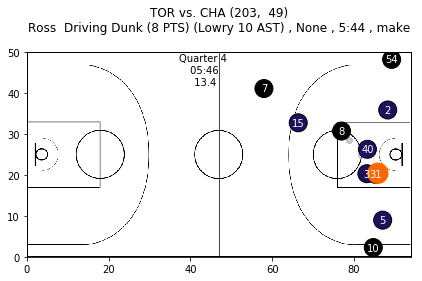

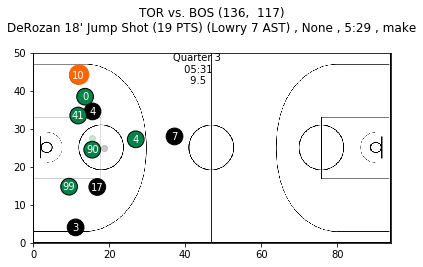

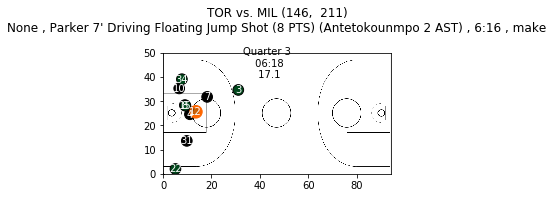

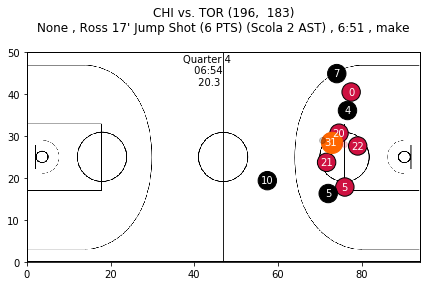

In [237]:
data_list_1 = divide_to_clusters(df,spectral_labels)

for i in xrange(4):
    data_to_draw = data_list_1[2].sample()
    print data_to_draw
    video_id = '{:010}'.format(int(data_to_draw.iloc[0]['video_id']))
    event = int(data_to_draw.iloc[0]['shot_event_list'])
    moment = int(data_to_draw.iloc[0]['shot_moment_list'])
    draw_court(video_id, event, moment)

# Clustering the rest

In [219]:
next_df = new_df[labels == 0]
next_X = next_df.as_matrix()

In [220]:
bandwidth = estimate_bandwidth(next_X, quantile=0.2, n_samples=500)
next_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
next_ms.fit(next_X)
next_labels = next_ms.labels_
next_cluster_centers = next_ms.cluster_centers_

In [221]:
cluster_centers = next_ms.cluster_centers_
next_labels_unique, next_count = np.unique(next_labels, return_counts = True)
n_clusters_ = len(next_labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 2


In [222]:
print next_count
print next_cluster_centers

[614 324]
[[ 26.56116541  24.55985031  14.33441896   3.824544     0.8464433 ]
 [  8.7056308   16.9583403    8.48891529   5.34318654   0.92271552]]


938 938
      shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
242  25.094427   31.707812   36.873659        24.179923        19.007305   

     defender_assist_1  defender_assist_2  assist_dist  travel_dist  \
242          29.103765          29.324228    13.345113    10.290674   

     time_to_shot  shot_event_list  shot_moment_list  video_id  
242          2.04             52.0             245.0  21500219  
event 52/225, moment: 245/650
      shot_loc  assist_loc  caught_loc  defender_shot_1  defender_shot_2  \
963  24.564269   32.926578   24.361062        20.279799        22.266397   

     defender_assist_1  defender_assist_2  assist_dist  travel_dist  \
963          23.350855          22.501932    12.125692     3.855668   

     time_to_shot  shot_event_list  shot_moment_list  video_id  
963           0.8             83.0             271.0  21500421  
event 83/265, moment: 271/575


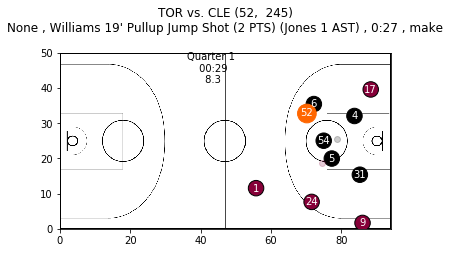

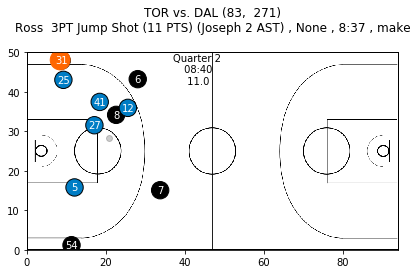

In [224]:
new_data_list = divide_to_clusters(data_list_1[0], next_labels)

for i in xrange(2):
    data_to_draw = new_data_list[0].sample()
    print data_to_draw
    video_id = '{:010}'.format(int(data_to_draw.iloc[0]['video_id']))
    event = int(data_to_draw.iloc[0]['shot_event_list'])
    moment = int(data_to_draw.iloc[0]['shot_moment_list'])
    draw_court(video_id, event, moment)